### Optimal control of the noisy FHN model
This notebook shows how to compute the optimal control signal for the noisy FHN model for a simple example task

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. In a deterministic system, the optimal control signal should converge to the input signal. In a noisy system, this should not be possible precisely, but only approximately, depending on the noise strength.

In [2]:
# We import the model
fhn = FHNModel()
fhn.params.sigma_ou = 0.

# Some parameters to define stimulation signals
dt = fhn.params["dt"]
duration = 40.
amplitude = 1.
period = duration/4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(2.*np.pi*np.arange(0,duration-0.2, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
fhn.params["duration"] = duration
x_init = 0.
y_init = 0.
fhn.params["xs_init"] = np.array([[x_init]])
fhn.params["ys_init"] = np.array([[y_init]])

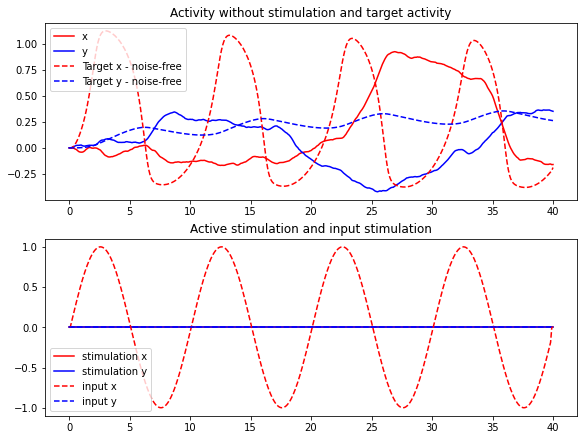

In [3]:
# We set the stimulus in x and y variables, and run the simulation in a noise-free system
fhn.params["x_ext"] = input
fhn.params["y_ext"] = zero_input
fhn.run()

# Define the result of the stimulation as target
x_target = np.vstack( [0., fhn.x.T])
y_target = np.vstack( [0., fhn.y.T])
target = np.column_stack(( [x_target, y_target] )).T

# Remove stimuli and re-run the simulation with noise
# Change sigma_ou_parameter to adjust the noise strength
fhn.params['sigma_ou'] = 0.1
fhn.params['tau_ou'] = 1.
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
fhn.run()

# combine initial value and simulation result to one array
x = np.vstack( [x_init, fhn.x.T])
y = np.vstack( [y_init, fhn.y.T])

fig, ax = plt.subplots( 2,1, figsize=(8,6), constrained_layout=True)

# Plot the target (dashed line) and unperturbed activity
t_array = np.arange(0, duration+dt, dt)

ax[0].plot(t_array, x, label="x", color=color_x)
ax[0].plot(t_array, y, label="y", color=color_y)
ax[0].plot(t_array, x_target, linestyle='dashed', label="Target x - noise-free", color=color_x)
ax[0].plot(t_array, y_target, linestyle='dashed', label="Target y - noise-free", color=color_y)
ax[0].legend()
ax[0].set_title("Activity without stimulation and target activity")

# Plot the target control signal (dashed line) and "initial" zero control signal
ax[1].plot(t_array, zero_input[0,:], label="stimulation x", color=color_x)
ax[1].plot(t_array, zero_input[0,:], label="stimulation y", color=color_y)
ax[1].plot(t_array, input[0,:], linestyle='dashed', label="input x", color=color_x)
ax[1].plot(t_array, zero_input[0,:], linestyle='dashed', label="input y", color=color_y)
ax[1].legend()
ax[1].set_title("Active stimulation and input stimulation")

plt.show()

The target is a periodic oscillation of x and y variable (computed in deterministic, noise-free system).

The noisy, undistrubed system fluctuates around zero.

For the optimization, you can now set several new parameters:
- M: the number of noise realizations that the algorithm averages over. Default=1
- M_validation: the number of noise realization the final cost is computed from. Default=1000
- validate_per_step: If True, the cost for each step is computed averaging over M_validation instead of M realizations, this takes much longer. Default=False
- method: determines, how the noise averages are computed. Results may vary for different methods depending on the specific task. Choose from ['3']. Default='3'

Please note:
- higher number of iterations does not promise better results for computations in noisy systems. The cost will level off at some iteration number, and start increasing again afterwards. Make sure not to perform too many iterations.
- M, M_validation should increase with sigma_ou model parameter
- validate_per_step does not impact the control result

Let's optimize with the following parameters: M=20, method='3', iterations=100

if you want to study a deterministic system, please set model parameter "sigma_ou" to zero
/home/lena/Promotion/neurolib/neurolib/optimal_control/oc_fhn/oc_fhn_jit.py:44: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 2d, C))
  - (fx[:, ind + 1] + adjoint_state[:, ind + 1] @ hx[ind + 1]) * dt
/home/lena/.local/lib/python3.9/site-packages/numba/core/typing/npydecl.py:937: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 2d, C))
  warnings.warn(NumbaPerformanceWarning(msg))
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


diverging model output, decrease step size to  0.5
diverging model output, decrease step size to  0.25
diverging model output, decrease step size to  0.125
diverging model output, decrease step size to  0.0625
Cost in iteration 10: 72.82481433245958


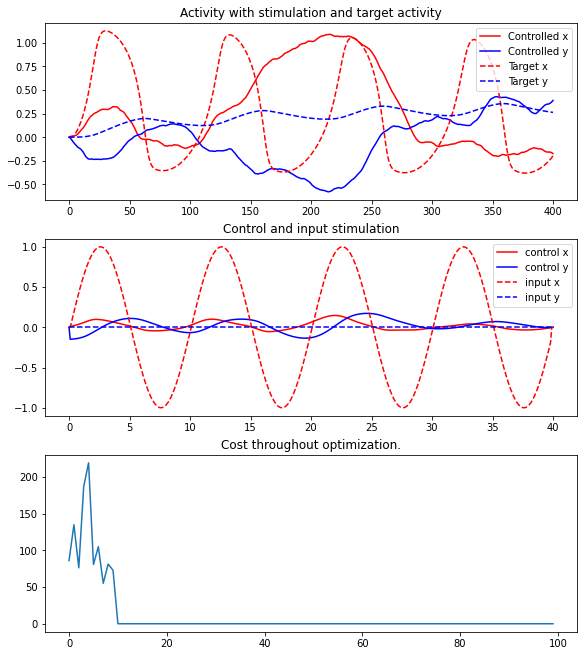

In [5]:
# We load the optimal control class
# print array (optinal parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
fhn_controlled = oc_fhn.OcFhn(fhn, target, w_p=1, w_2=0, print_array=np.arange(0,101,10),
                              M=20, M_validation=500, validate_per_step=True, method='3')

# We run 100 iterations of the optimal control gradient descent algorithm
fhn_controlled.optimize(100)

# combine the initial values and time series of controlled model to one array
x_oc = np.vstack( [fhn_controlled.model.params["xs_init"], fhn_controlled.model.x.T])
y_oc = np.vstack( [fhn_controlled.model.params["ys_init"], fhn_controlled.model.y.T])

control = fhn_controlled.control

fig, ax = plt.subplots( 3,1, figsize=(8,9), constrained_layout=True)

# Plot the target (dashed line) and controlled activity
ax[0].plot(x_oc, label="Controlled x", color=color_x)
ax[0].plot(y_oc, label="Controlled y", color=color_y)
ax[0].plot(x_target, linestyle='dashed', label="Target x", color=color_x)
ax[0].plot(y_target, linestyle='dashed', label="Target y", color=color_y)
ax[0].legend()
ax[0].set_title("Activity with stimulation and target activity")

# Plot the target control signal (dashed line) and control signal after 500 iterations
ax[1].plot(t_array, control[0,:], label="control x", color=color_x)
ax[1].plot(t_array, control[1,:], label="control y", color=color_y)
ax[1].plot(t_array, input[0,:], linestyle='dashed', label="input x", color=color_x)
ax[1].plot(t_array, zero_input[0,:], linestyle='dashed', label="input y", color=color_y)
ax[1].legend()
ax[1].set_title("Control and input stimulation")

# Plot the cost as function of iteration
ax[2].plot(fhn_controlled.cost_history)
ax[2].set_title("Cost throughout optimization.")
plt.show()

Let's do the same thing with different parameters: M=100, method='3', iterations=30

ERROR:root:nan in model output!


diverging model output, decrease step size to  0.5


ERROR:root:nan in model output!


diverging model output, decrease step size to  0.25
Mean cost in iteration 10: 74.92863879141208
Mean cost in iteration 20: 60.32467055029916
Mean cost in iteration 30: 50.72710395619244


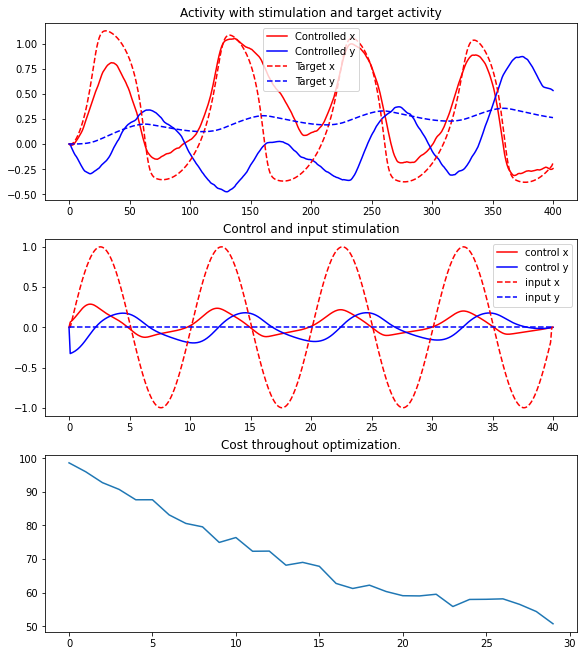

In [52]:
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
fhn_controlled = oc_fhn.OcFhn(fhn, target, w_p=1, w_2=0, print_array=np.arange(0,31,5),
                              M=100, M_validation=500, validate_per_step=True, method='3')

fhn_controlled.optimize(30)

x_oc = np.vstack( [fhn_controlled.model.params["xs_init"], fhn_controlled.model.x.T])
y_oc = np.vstack( [fhn_controlled.model.params["ys_init"], fhn_controlled.model.y.T])
control = fhn_controlled.control

fig, ax = plt.subplots( 3,1, figsize=(8,9), constrained_layout=True)

ax[0].plot(x_oc, label="Controlled x", color=color_x)
ax[0].plot(y_oc, label="Controlled y", color=color_y)
ax[0].plot(x_target, linestyle='dashed', label="Target x", color=color_x)
ax[0].plot(y_target, linestyle='dashed', label="Target y", color=color_y)
ax[0].legend()
ax[0].set_title("Activity with stimulation and target activity")

ax[1].plot(t_array, control[0,:], label="control x", color=color_x)
ax[1].plot(t_array, control[1,:], label="control y", color=color_y)
ax[1].plot(t_array, input[0,:], linestyle='dashed', label="input x", color=color_x)
ax[1].plot(t_array, zero_input[0,:], linestyle='dashed', label="input y", color=color_y)
ax[1].legend()
ax[1].set_title("Control and input stimulation")

ax[2].plot(fhn_controlled.cost_history)
ax[2].set_title("Cost throughout optimization.")
plt.show()

Apparently, for this problem, the first approach is more efficient.

The larger M leads to a more steady decrease in cost in the second approach.